In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('final_data.csv')

# Load multilingual BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Tokenize input texts
tokenized_texts = tokenizer(list(df['Tweet']), padding=True, truncation=True, return_tensors="pt")

# Convert string labels to numerical labels
label_map = {label: index for index, label in enumerate(df['party'].unique())}
df['label'] = df['party'].map(label_map)

# Prepare labels
labels = torch.tensor(df['label'])

# Create TensorDataset
dataset = TensorDataset(tokenized_texts['input_ids'], tokenized_texts['attention_mask'], labels)

# Define batch size
batch_size = 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
# Create DataLoader
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

# Splitting the dataset into train and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize and prepare validation dataset
validation_tokenized_texts = tokenizer(list(validation_df['Tweet']), padding=True, truncation=True, return_tensors="pt")
validation_labels = torch.tensor(validation_df['label'].tolist())  # Convert Series to list
validation_dataset = TensorDataset(validation_tokenized_texts['input_ids'], validation_tokenized_texts['attention_mask'], validation_labels)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

# Define the LSTM model
class BERTLSTMClassifier(nn.Module):
    def __init__(self, bert_model, lstm_hidden_size, num_labels):
        super(BERTLSTMClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.lstm = nn.LSTM(input_size=bert_model.config.hidden_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=False)  # You can adjust bidirectional as needed
        self.linear = nn.Linear(lstm_hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        lstm_out, _ = self.lstm(pooled_output.unsqueeze(1))
        logits = self.linear(lstm_out[:, -1])  # Get output from the last time step
        return logits

# Initialize the BERT model and the BERTLSTMClassifier
bert_model = BertModel.from_pretrained("bert-base-multilingual-cased")
num_labels = len(df['party'].unique())  # Number of unique labels
lstm_hidden_size = 128  # Adjust as needed

model = BERTLSTMClassifier(bert_model, lstm_hidden_size, num_labels)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training parameters
epochs = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Get the device
model.to(device)  # Move the model to the device

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTLSTMClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
# Lists to store training loss and accuracy
train_loss_values = []
train_accuracy_values = []

# Training loop


In [ ]:
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training step
    for batch in tqdm(dataloader, desc="Iteration"):
        batch = tuple(t.to(device) for t in batch)  # Move input tensors to the device
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = nn.CrossEntropyLoss()(outputs, batch[2])  # Correctly pass labels
        loss.backward()
        optimizer.step()

        # Compute training loss
        epoch_loss += loss.item()

        # Compute training accuracy
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_predictions += batch[2].size(0)

    # Calculate average epoch loss and accuracy
    avg_epoch_loss = epoch_loss / len(dataloader)
    train_loss_values.append(avg_epoch_loss)
    train_accuracy = correct_predictions / total_predictions
    train_accuracy_values.append(train_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}')


Epoch 1/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 1/4, Loss: 0.5882, Accuracy: 0.8211
Epoch 2/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 2/4, Loss: 0.2390, Accuracy: 0.9201
Epoch 3/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 3/4, Loss: 0.1771, Accuracy: 0.9369
Epoch 4/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 4/4, Loss: 0.1858, Accuracy: 0.9336


Validation:   0%|          | 0/77 [00:00<?, ?it/s]

Validation Accuracy: 0.9458


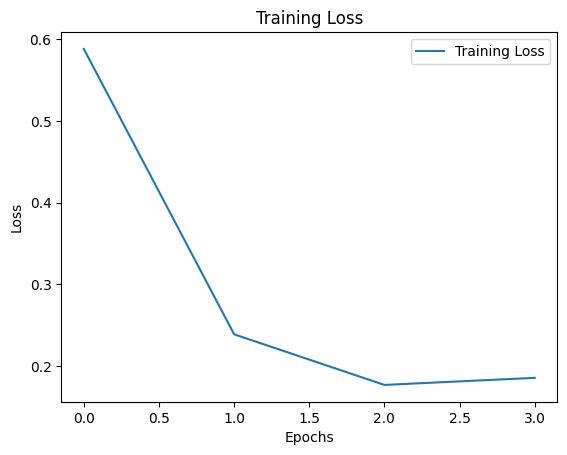

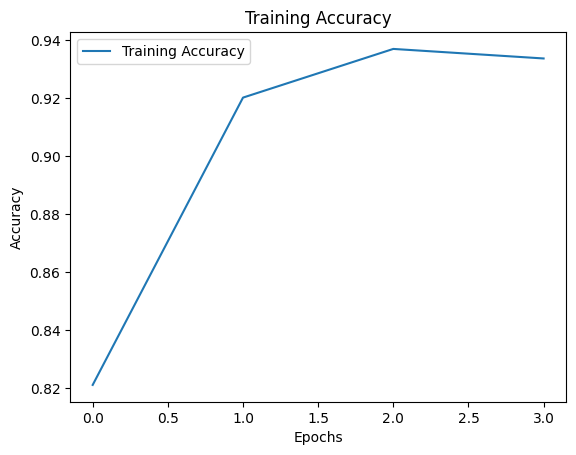

In [ ]:
model.eval()
correct_val_predictions = 0
total_val_predictions = 0

for batch in tqdm(validation_dataloader, desc="Validation"):
    batch = tuple(t.to(device) for t in batch)  # Move input tensors to the device
    with torch.no_grad():
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        _, predicted_labels = torch.max(outputs, 1)
        correct_val_predictions += (predicted_labels == batch[2]).sum().item()
        total_val_predictions += batch[2].size(0)

# Calculate validation accuracy
val_accuracy = correct_val_predictions / total_val_predictions
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Plotting the training loss
plt.plot(train_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plotting the training accuracy
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

Predicting:   0%|          | 0/77 [00:00<?, ?it/s]

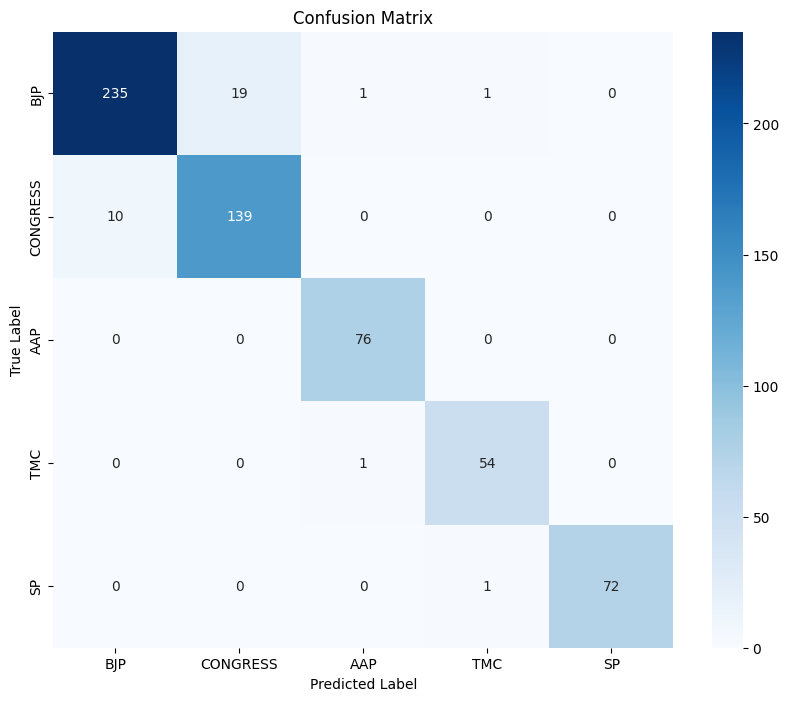

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set model to evaluation mode
model.eval()

# List to store predicted labels
predicted_labels_list = []

# Loop through validation dataloader for predictions
for batch in tqdm(validation_dataloader, desc="Predicting"):
    batch = tuple(t.to(device) for t in batch)  # Move input tensors to the device
    with torch.no_grad():
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        _, predicted_labels = torch.max(outputs, 1)
        predicted_labels_list.extend(predicted_labels.cpu().numpy().tolist())

# Calculate the confusion matrix
confusion_mat = confusion_matrix(validation_df['label'], predicted_labels_list)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


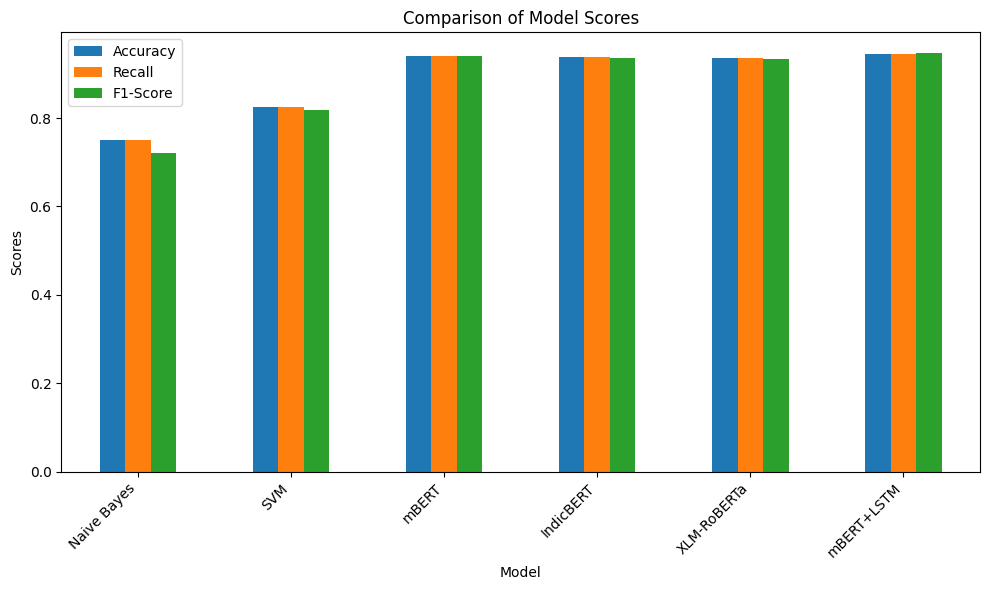

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data for the models
data = {
    "Model": ["Naive Bayes", "SVM", "mBERT", "IndicBERT", "XLM-RoBERTa", "mBERT+LSTM"],
    "Accuracy": [0.7505, 0.8245, 0.9392, 0.9376, 0.9360, 0.9458],
    "Recall": [0.7505, 0.8245, 0.9392, 0.9376, 0.9360, 0.9458],
    "F1-Score": [0.7213, 0.8182, 0.9395, 0.9362, 0.9342, 0.9465]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set the Model column as the index
df.set_index("Model", inplace=True)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(kind='bar', ax=ax)
ax.set_ylabel("Scores")
ax.set_title("Comparison of Model Scores")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

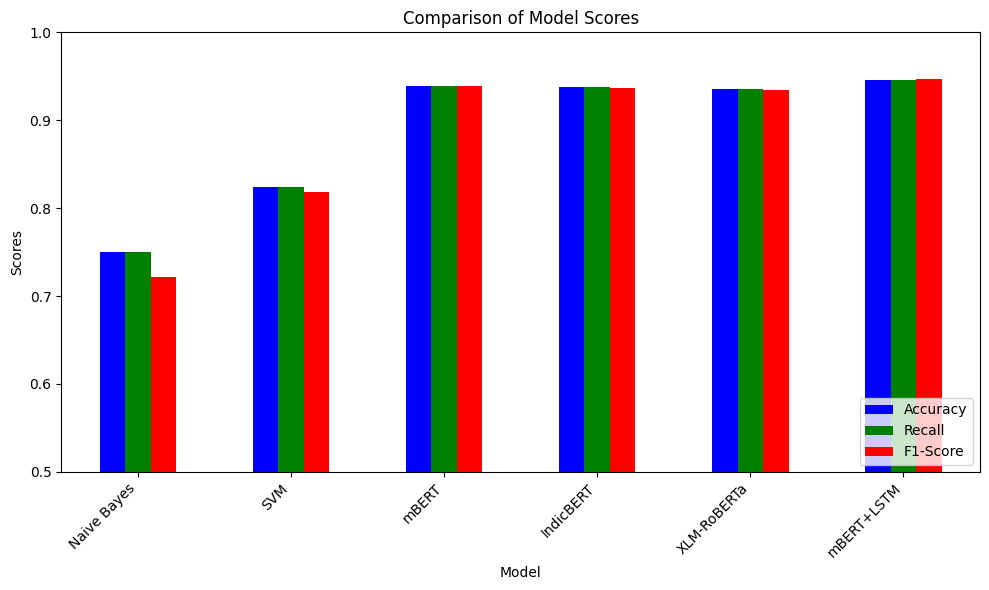

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data for the models
data = {
    "Model": ["Naive Bayes", "SVM", "mBERT", "IndicBERT", "XLM-RoBERTa", "mBERT+LSTM"],
    "Accuracy": [0.7505, 0.8245, 0.9392, 0.9376, 0.9360, 0.9458],
    "Recall": [0.7505, 0.8245, 0.9392, 0.9376, 0.9360, 0.9458],
    "F1-Score": [0.7213, 0.8182, 0.9395, 0.9362, 0.9342, 0.9465]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set the Model column as the index
df.set_index("Model", inplace=True)

# Plotting the bar chart with adjusted y-axis limits
fig, ax = plt.subplots(figsize=(10, 6))

# Custom colors for bars
colors = ['blue', 'green', 'red']

# Plotting bars for Accuracy, Recall, F1-Score
df.plot(kind='bar', ax=ax, color=colors)

ax.set_ylabel("Scores")
ax.set_title("Comparison of Model Scores")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 1.0)  # Set y-axis limits from 0.5 to 1.0
plt.legend(loc='lower right')  # Adjust legend location
plt.tight_layout()
plt.show()



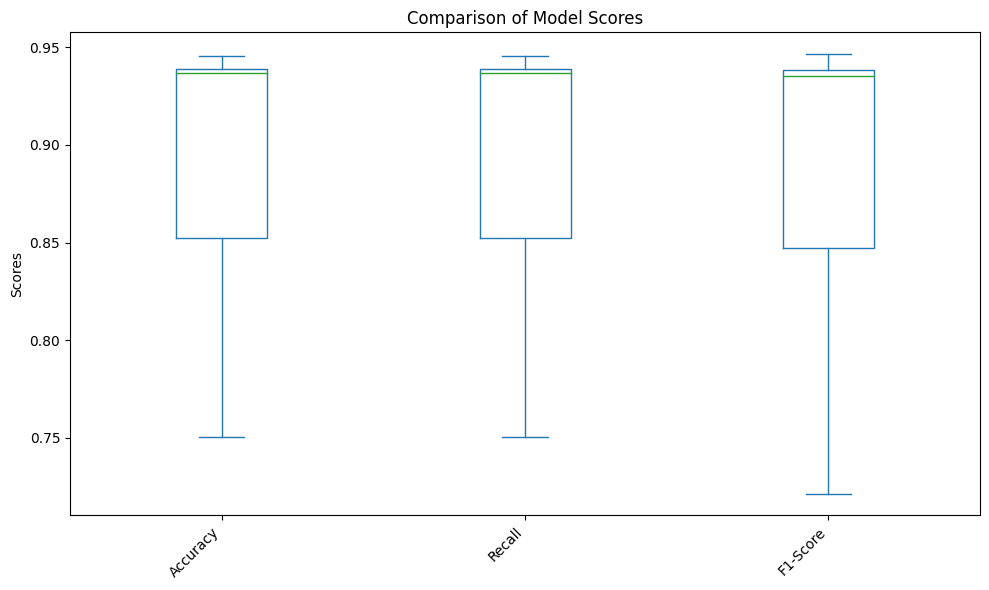

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data for the models
data = {
    "Model": ["Naive Bayes", "SVM", "mBERT", "IndicBERT", "XLM-RoBERTa", "mBERT+LSTM"],
    "Accuracy": [0.7505, 0.8245, 0.9392, 0.9376, 0.9360, 0.9458],
    "Recall": [0.7505, 0.8245, 0.9392, 0.9376, 0.9360, 0.9458],
    "F1-Score": [0.7213, 0.8182, 0.9395, 0.9362, 0.9342, 0.9465]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Plotting the box plot
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(kind='box', ax=ax)
ax.set_ylabel("Scores")
ax.set_title("Comparison of Model Scores")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
